In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

data_dir = 'F:/crs/proj/2025_NOPP_comparison/helene_water_level/DesignSafe/'
# Data is recorded at 16 Hz, but time is only precise to 1 s
fn = '2024-Sept-30_RAPID-WG01_Data.CSV' # removed first three records so it starts on even second

def load_high_freq_data(csv_file):
    # Load CSV file
    df = pd.read_csv(csv_file)

    # # Ensure columns exist
    required_columns = {"date", "time", "pressure"}
    if not required_columns.issubset(df.columns):
        raise KeyError(f"Missing required columns: {required_columns - set(df.columns)}")

    # Combine date and time columns into a single datetime column
    df["datetime"] = pd.to_datetime(df["date"] + " " + df["time"], format="mixed")

    # Generate sub-second timestamps (assuming 16 samples per second)
    df["sample_index"] = df.groupby("datetime").cumcount()  # Count samples per second
    df["milliseconds"] = (df["sample_index"] * (1000 / 16)).astype(int)  # Convert to milliseconds

    # Create final datetime with microsecond precision
    df["datetime"] = df["datetime"] + pd.to_timedelta(df["milliseconds"], unit="ms")

    # Drop intermediate columns
    df = df.drop(columns=["date", "time", "sample_index", "milliseconds"])

    return df


def lowpass_and_resample(df, column='pressure', sample_rate=16, cutoff_freq=1/25, resample_interval='6min', order=4):
    """
    Apply a Butterworth low-pass filter and resample the data to a lower frequency.
    
    Parameters:
    - df: DataFrame with 'datetime' and pressure column
    - column: the name of the column to filter
    - sample_rate: original sampling rate in Hz
    - cutoff_freq: low-pass filter cutoff frequency in Hz
    - resample_interval: string like '6T' for 6-minute intervals
    - order: filter order
    
    Returns:
    - Resampled DataFrame with filtered pressure
    """
    # Design Butterworth filter
    nyquist = 0.5 * sample_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)

    # Apply filter
    df['pressure_filtered'] = filtfilt(b, a, df[column])

    # Resample to specified interval
    df_resampled = (
        df.set_index('datetime')['pressure_filtered']
        .resample(resample_interval)
        .mean()
        .reset_index()
    )

    return df_resampled


def smooth_and_resample(df, window_size=9600, resample_interval="10T"):
    """
    Smooths the pressure data using a rolling mean and resamples it to 10-minute intervals.
    
    Parameters:
    - df: Pandas DataFrame with 'datetime' and 'pressure' columns.
    - window_size: Number of samples for rolling mean (default: 9600 for 10 minutes at 16 Hz).
    - resample_interval: Resampling frequency ('10T' for 10 minutes).
    
    Returns:
    - Resampled DataFrame with smoothed pressure data.
    """
    # Apply a rolling mean for smoothing
    df["smoothed_pressure"] = df["pressure"].rolling(window=window_size, min_periods=1, center=True).mean()

    # Resample to 10-minute intervals (taking mean)
    df_resampled = df.set_index("datetime").resample(resample_interval).mean().reset_index()

    return df_resampled


df = load_high_freq_data(data_dir+fn)

# Display first few rows
print(df.head())

df_smooth_6min = lowpass_and_resample(
    df,
    column='pressure',
    sample_rate=16,
    cutoff_freq=1/25,
    resample_interval='6min'
)

print(df_smooth_6min.head())

   pressure                datetime
0    1005.8 2024-09-25 07:58:38.000
1    1005.6 2024-09-25 07:58:38.062
2    1005.5 2024-09-25 07:58:38.125
3    1005.7 2024-09-25 07:58:38.187
4    1005.6 2024-09-25 07:58:38.250
             datetime  pressure_filtered
0 2024-09-25 07:54:00        1005.701536
1 2024-09-25 08:00:00        1005.418852
2 2024-09-25 08:06:00        1004.523270
3 2024-09-25 08:12:00        1003.975216
4 2024-09-25 08:18:00        1003.523582


In [2]:
# Load second CSV file
met_file = 'CO-OPS_8727520_met.csv'  # Replace with your filename
df_met = pd.read_csv(data_dir+met_file)

# Parse datetime from "Date" and "Time (GMT)"
df_met["datetime"] = pd.to_datetime(df_met["Date"] + " " + df_met["Time (GMT)"])
print(df_met.head())

         Date Time (GMT)  Wind Speed (m/s)  Wind Dir (deg)  Wind Gust (m/s)  \
0  2024/09/25      00:00               2.0             338              3.2   
1  2024/09/25      00:06               1.7             340              2.7   
2  2024/09/25      00:12               1.7             346              2.5   
3  2024/09/25      00:18               2.0             350              2.6   
4  2024/09/25      00:24               1.6             347              2.6   

   Air Temp (°C)  Baro (mb) Humidity (%) Visibility (km)            datetime  
0           29.1     1011.3            -               - 2024-09-25 00:00:00  
1           29.1     1011.3            -               - 2024-09-25 00:06:00  
2           29.0     1011.3            -               - 2024-09-25 00:12:00  
3           28.9     1011.4            -               - 2024-09-25 00:18:00  
4           28.8     1011.4            -               - 2024-09-25 00:24:00  


In [5]:
df_smooth_6min['datetime'] = pd.to_datetime(df_smooth_6min['datetime'])
df_met['datetime'] = pd.to_datetime(df_met['datetime'])

# Step 2: Merge the two dataframes on datetime
df_merged = pd.merge(df_smooth_6min, df_met[['datetime', 'Baro (mb)']], on='datetime', how='inner')

# Step 3: Subtract Baro (mb) from pressure_filtered and convert to decibars (1:1 conversion)
df_merged['pressure_corrected_dbar'] = (df_merged['pressure_filtered'] - df_merged['Baro (mb)'])/100.

# Step 4: Set datetime as the index
df_result = df_merged.set_index('datetime')

# Optional: display result
print(df_result.head())

                     pressure_filtered  Baro (mb)  pressure_corrected_dbar
datetime                                                                  
2024-09-25 07:54:00        1005.701536     1010.8                -0.050985
2024-09-25 08:00:00        1005.418852     1010.7                -0.052811
2024-09-25 08:06:00        1004.523270     1010.8                -0.062767
2024-09-25 08:12:00        1003.975216     1010.7                -0.067248
2024-09-25 08:18:00        1003.523582     1010.6                -0.070764


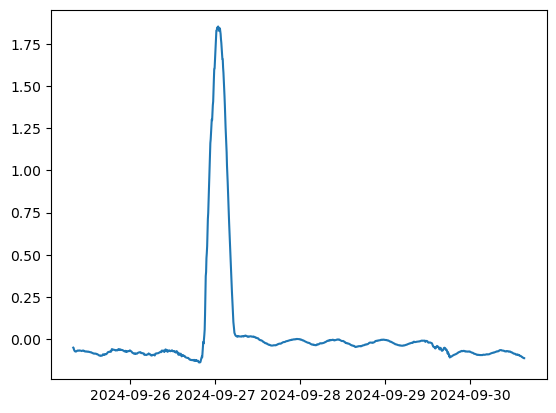

In [6]:
df_result = df_result.reset_index()
plt.plot( df_result['datetime'],df_result['pressure_corrected_dbar'])